# Installs and Imports

In [ ]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/BullingerDigitalLMFootnotes/git_repo/evaluate


/content/drive/MyDrive/BullingerDigitalLMFootnotes/git_repo/evaluate


In [ ]:
%pip install evaluate
%pip install transformers
%pip install bert-score
%pip install rouge_score

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=870351ba96ea060496aed3a973db1b4a9f5480904967f395be40948007608564
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from evaluate_utils import *
import pandas as pd
import os
def get_merged_df(human_df, machine_df, filepath, relable=False, test=False):
  if os.path.exists(filepath):
    merged_df = pd.read_csv(filepath)
    # check if merged_df has any unnamed columns, that just replicate the old index
    for col in merged_df.columns:
      if col.startswith("Unnamed"):
        merged_df = merged_df.drop(col, axis=1)
        merged_df.to_csv(filepath, index=False)
  else:
    merged_df = machine_df.merge(human_df, on=["letter_id", "n_footnote"])
    merged_df = merged_df[["letter_id", "n_footnote", "generated_footnote", "xml_footnote", "label"]]
    merged_df.to_csv(filepath, index=False)
  return merged_df

# since I redid the labeling, also initially these dfs did not have the labels...
def relabel(human_df, filepath, test=True):
  merged_df = pd.read_csv(filepath)
  # take out the old label column from merged df if it exists
  if "label" in merged_df.columns:
    merged_df = merged_df.drop("label", axis=1)
  label_df = human_df[["letter_id", "n_footnote", "label"]].copy()
  merged_df = merged_df.merge(label_df[["letter_id", "n_footnote", "label"]], on=["letter_id", "n_footnote"])

  if test:  # test before I screw up my data...
    return merged_df
  else:
    merged_df.to_csv(filepath, index=False)
    print(f"realbled {filepath}")


pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

human_footnotes_df = pd.read_csv("../../data/footnote_downsized_df_new.csv")
human_footnotes_df["xml_footnote"] = human_footnotes_df["xml_footnote"].apply(remove_outer_note_tag)

In [ ]:
model_name_map = {
    "llama-instruct-base": "Meta-Llama-3.1-8B-Instruct",
    "llama-instruct-base-large": "Meta-Llama-3.1-70B-Instruct-bnb-4bit",
    "llama-instruct-add-example": "bullingerLM_llama-3.1-8B-Instruct_example",
    "llama-instruct-add": "BullingerDigitalLMFootnotes_instruct-add",
    "llama-instruct-qa": "BullingerDigitalLMFootnotes_llama_instruct_qa",
    "llama-instruct-qa-add": "BullingerDigitalLMFootnotes_llama_instruct_qa_add",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "gpt-4o": "gpt-4o-2024-08-06"
}

EVAL_FOLDER = "../../data/evaluation/"

def average(df):
  columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
  averages = []
  for col in columns:
    averages.append(df[col].mean())
  return averages

def compare(models:list[str], split:str, prompt):
  columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
  results = {}
  for model in models:
    filename = f"evaluation-{model_name_map[model]}_{prompt}_{split}.csv"
    filepath = os.path.join(EVAL_FOLDER, filename)
    if not os.path.exists(filepath):
      print(f"No evaluation yet for {model} on {prompt}, {split}")
      continue
    df = pd.read_csv(filepath)
    results[model] = average(df)
  result_df = pd.DataFrame(columns=columns)
  for model in results:
    result_df.loc[model] = results[model]
  return result_df

# find missing experiments:
def find_missing_experiments(models, splits, prompts):
# go through all combinations of splits, prompts and models
  for split in splits:
    for prompt in prompts:
      for model in models:
        filename = f"evaluation-{model_name_map[model]}_{prompt}_{split}.csv"
        filepath = os.path.join(EVAL_FOLDER, filename)
        if not os.path.exists(filepath):
          print(f"No evaluation yet for {model} on {prompt}, {split}")

# evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_test.csv

In [ ]:
# run over all files in the evaluate folder, and relabel
# This was done because I redid the classification, but did not want to redo the sampling, and generating
if False:
  for filename in os.listdir(EVAL_FOLDER):
    if filename.endswith(".csv"):
      merged_df = pd.read_csv(os.path.join(EVAL_FOLDER, filename))
      relabel(human_footnotes_df, os.path.join(EVAL_FOLDER, filename), test=False)

#

realbled ../../data/evaluation/evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_dev.csv
realbled ../../data/evaluation/evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_example.csv
realbled ../../data/evaluation/evaluation-gpt-4o-2024-08-06_instruct_add_example.csv
realbled ../../data/evaluation/evaluation-gpt-4o-mini-2024-07-18_instruct_add_dev.csv
realbled ../../data/evaluation/evaluation-gpt-4o-mini-2024-07-18_instruct_add_example.csv
realbled ../../data/evaluation/evaluation-gpt-4o-mini-2024-07-18_instruct_add_test.csv
realbled ../../data/evaluation/evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_test.csv
realbled ../../data/evaluation/evaluation-bullingerLM_llama-3.1-8B-Instruct_example_instruct_add_example.csv
realbled ../../data/evaluation/evaluation-BullingerDigitalLMFootnotes_instruct-add_instruct_add_example.csv
realbled ../../data/evaluation/evaluation-BullingerDigitalLMFootnotes_instruct-add_instruct_add_dev.csv
realbled ../../data/evaluation/evaluation-BullingerDigit

In [ ]:
splits = ["example"]
prompts = ["instruct_add", "instruct_qa"]
models = model_name_map.keys()
find_missing_experiments(models, splits, prompts)

No evaluation yet for llama-instruct-base-large on instruct_add, example
No evaluation yet for llama-instruct-add-example on instruct_qa, example
No evaluation yet for gpt-4o on instruct_qa, example


# Evaluate Llama models

In [ ]:
SPLIT = "example"
PROMPT = "instruct_qa"
MODEL_NAME = "llama-instruct-qa-add"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/llama/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
eval_df_filepath = os.path.join(EVAL_FOLDER, eval_df_filename)
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filepath)
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [ ]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,label
0,11941,5,"Siehe dazu <ref target=""file11936"">Nr. 1890</ref>, Anm. 2.","Vgl. <bibl>HBBW XIII</bibl> 334, 10-14.",short
1,12561,60,"<persName ref=""p8418"" cert=""high"">Haller</persName>. -Siehe <bibl>HBBW</bibl> XVII 291, Anm. 10. -Zur Übermittlung des Schreibens durch <persName ref=""p8051"" cert=""high"">Ruman Ruman</persName> s. <bibl>HBBW</bibl> XVII 290, Anm. 5.","Gemeint ist Bullinger; vgl. <ref target=""file12511"">Nr. 2464</ref>,45f.",misc
2,10650,2,"Vgl. <bibl>HBBW</bibl> IV <ref target=""file10112"">[Nr. 81]</ref>, S. 84, Anm. 12.","Wer noch, außer <persName ref=""p5618"" cert=""high"">Heinrich Lavater</persName> und <persName ref=""p8459"" cert=""high"">Otto Werdmüller</persName>, als Kostgänger bei <persName ref=""p315"" cert=""high"">Jakob Bedrot</persName> wohnte, ist nicht bekannt.",missing
3,11941,8,"<persName ref=""p467"" cert=""high"">Bucer</persName> bezieht sich auf oben <ref target=""file11936"">Nr. 1890</ref>, 1-9.","Wahrscheinlich eine Anspielung seitens <persName ref=""p1227"" cert=""high"">Froschauers</persName> auf <persName ref=""p1278"" cert=""high"">Gasts</persName> Vorhaben bzw. Wunsch in <placeName ref=""l28"" cert=""high"">Basel</placeName>; s. oben <ref target=""file11919"">Nr. 1873</ref>, 11f.",misc
4,12561,43,"Siehe dazu <ref target=""file12544"">Nr. 2497</ref>,<ptr target=""qvzl17157-1"" type=""qv""/>.","Die Klause Ehrenberg; s. <ref target=""file12545"">Nr. 2498</ref>, Anm. 96.",misc
...,...,...,...,...,...
69,12561,40,"Die von <placeName ref=""l41"" cert=""high"">Bern</placeName> in der oben Anm. 2 erwähnten Briefe.","Das Geheimalphabet (s. dazu <ref target=""file12550"">Nr. 2503</ref>,42-48; <ref target=""file12552"">Nr. 2505</ref>,6. 74), das Bullinger offensichtlich in seinem dem jungen Herrliberger anvertrauten Brief verwendet hat.",misc
70,12561,39,"Nr. 2509 vom 25. Juli. - Siehe dazu <ref target=""file12560"">Nr. 2513</ref>,<ptr target=""qvzl17175-6"" type=""qv""/>.","Bullingers Brief an <persName ref=""p8018"" cert=""high"">Haller</persName> vom 10. Juli (<ref target=""file12541"">Nr. 2494</ref>); s. <ref target=""file12571"">Nr. 2524</ref>,2-4.",misc
71,12561,38,"Nr. 2509 vom 23. Juli. - Siehe dazu oben <ref target=""file12559"">Nr. 2512</ref>, Anm. 5.","Brief <ref target=""file12554"">Nr. 2507</ref> vom 22. Juli.",misc
72,11507,20,"<persName ref=""p6355"" cert=""high"">Hieronymus</persName>, Commentarius in epistolam ad Hebr. (<bibl>CChr-L</bibl> CXXVII 15, 2-16, 12).","Bullinger, Commentarius in epistolam ad Hebraeos, Zürich (<persName ref=""p1227"" cert=""high"">Christoph Froschauer</persName>) 1532 (<bibl>HBBibl</bibl> I 38) (gedacht ist wohl an die Auslegung von <cit type=""bible""><ref>Hebr 10, 32-34</ref></cit>, bes. f. 112v.; vgl. die ausführliche Kritik an der Messe, f. 98r.-107r.).","bible, bibl"


In [ ]:
merged_df["label"].unique()

array(['misc', 'missing', 'inner_ref', 'self_ref', 'bible', 'short',
       'bibl', 'inner_ref, lex', 'self_ref, missing', 'bible, bibl',
       'self_ref, bible'], dtype=object)

In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 112/112 [00:10<00:00, 10.85it/s]


calculating BLEU and ROUGE without markup


100%|██████████| 112/112 [00:09<00:00, 12.25it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

Computing BERT with Mark-Up


  0%|          | 0/112 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 112/112 [00:35<00:00,  3.15it/s]


Computing BERT without Markup


100%|██████████| 112/112 [00:16<00:00,  6.97it/s]


# Evaluate GPT 4o-mini generation
Note that for the filename creation here, '-' is used instead of '_'<br>
Is this optimal? No! but too late to change...

In [ ]:
SPLIT = "example"
PROMPT = "instruct_qa"
MODEL_NAME = "gpt-4o-mini"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
eval_df_filepath = os.path.join(EVAL_FOLDER, eval_df_filename)
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, os.path.join(EVAL_FOLDER, eval_df_filename))
evaluator = genEvaluator(merged_df)

In [ ]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bleu_with,rouge_with,bleu_without,rouge_without,bert_with,bert_without,label
0,11298,11,"Johannes Buchser, ein reformierter Theologe und einer der Mitstreiter von Heinrich Bullinger, war aktiv in der Förderung der reformatorischen Prinzipien in der Schweiz. In diesem Kontext ist er relevant, da seine Zusammenarbeit mit anderen Reformatoren und sein Einfluss auf die Gemeinden in der Region während der Reformation bedeutend waren. Sein Verhältnis zu dem auch genannten Ioannis Surani weist auf eine enge Verbindung innerhalb des reformierten geistlichen Netzwerks hin, die für die Verbreitung reformatorischer Ideen und die Organisation der reformierten Kirche in der Region von Bedeutung war.","<persName ref=""p261"" cert=""high"">Johannes Buchser</persName>, Pfarrer in <placeName ref=""l497"" cert=""high"">Suhr</placeName> (Kt. Aargau). - <persName ref=""p8364"" cert=""high"">Gering</persName> war 1538 vom Zürcher Ehegericht von dessen Schwester <persName ref=""p4928"" cert=""high"">Sabinella</persName> geschieden worden (vgl. Zürich SIA, YY 1. 5, S. 1026f, und Zürich ZB, Ms F 154, Nr. 5).",0.0,0.092105,0.0,0.109375,0.559381,0.615874,misc
1,11298,12,"Wilhelm von Fürstenberg (*circa 1480–1559) war ein bedeutender deutscher Adeliger und ein wichtiger Unterstützer der Reformbewegung im 16. Jahrhundert. Als Graf und Komtur des Johanniterordens spielte er eine zentrale Rolle in der Verwaltung und politischen Landschaft der Region Gengenbach, die damals als strategisch wichtig galt. Unter seiner Herrschaft wurde Gengenbach zu einem Ort, der sowohl für den politischen als auch für den religiösen Diskurs von Bedeutung war, insbesondere im Kontext der Auseinandersetzungen zwischen reformierten und katholischen Kräften im Heiligen Römischen Reich.","<persName ref=""p7492"" cert=""high"">Wilhelm von Fürstenberg</persName> verwaltete <placeName ref=""l1720"" cert=""high"">Gengenbach</placeName> als Pfandherr; vgl. Johannes Volker <hi>Wagner,</hi> Graf <persName ref=""p7492"" cert=""high"">Wilhelm von Fürstenberg</persName>, 1491-1549, und die politischgeistigen Mächte seiner Zeit, Stuttgart 1966. - Pariser Historische Studien, 4, S. 185f.",0.0,0.167832,0.0,0.195122,0.567983,0.629983,misc
2,11298,3,"Siehe hierzu auch Johannes Calvin, *Institutio Christianae Religionis*, Buch 2, Kapitel 8, wo die Gefahren der Nachlässigkeit in der Seelsorge thematisiert werden; sowie Martin Luther, *Von der Freiheit eines Christenmenschen*, 1520, in dem er die Bedeutung der Wachsamkeit im Glauben hervorhebt. Des Weiteren behandeln die *Confessio Augustana*, Artikel 12, und die Schriften von Philipp Melanchthon das Thema der Sorgfalt und deren Einfluss auf das christliche Leben.",Vgl. ebd. 19-30.,0.0,0.000000,0.0,0.000000,0.556883,0.556883,short
3,11298,4,"In diesem Kontext bezieht sich die ""ecclesiola huius agri"" auf die reformierten Gemeinden in der Region Zürich, zu denen unter anderem die Stadtgemeinde Zürich sowie angrenzende ländliche Gemeinden wie Winterthur, Baden und andere gehörten, die während der Reformation unter Bullingers Einfluss standen. Diese Gemeinden standen in engem Kontakt und Austausch, insbesondere durch die gemeinsamen kirchlichen und theologischen Anliegen der Reformatoren.","Die Kirche bestand aus den Gemeinden der Herrschaften <placeName ref=""l221"" cert=""high"">Horburg</placeName> und <placeName ref=""l411"" cert=""high"">Reichenweier</placeName>, denen <persName ref=""p1010"" cert=""high"">Erb</persName> als Superintendent vorstand; vgl. Johann <hi>Adam,</hi> Evangelische Kirchengeschichte der elsässischen Territorien bis zur französischen Revolution, Straßburg 1928, S. 297.",0.0,0.100000,0.0,0.120000,0.585560,0.648178,misc
4,11298,5,"Der Gedanke an ""Hoffnung gegen Hoffnung"" könnte biblisch in Römer 4,18 verankert sein, wo Abraham trotz widriger Umstände an die Verheißung Gottes glaubte. Auch Hebräer 11,1, das den Glauben als ""die Substanz der Dinge, die man hofft"" beschre

In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

calculating BLEU and ROUGE with markup


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 112/112 [00:09<00:00, 12.12it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 112/112 [00:09<00:00, 11.59it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

Computing BERT with Mark-Up


100%|██████████| 112/112 [00:24<00:00,  4.49it/s]


Computing BERT without Markup


100%|██████████| 112/112 [00:15<00:00,  7.29it/s]


# Correlation of Evaluators

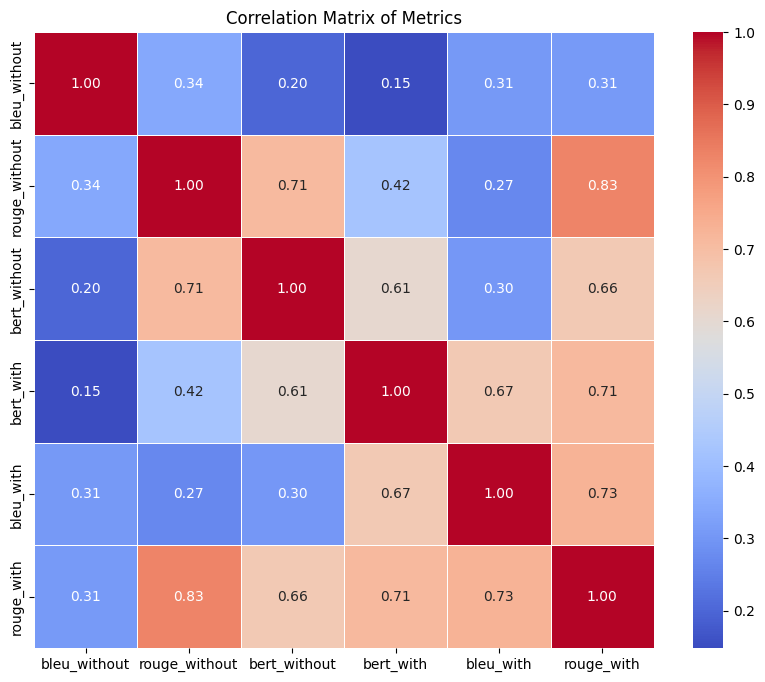

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
correlation_matrix = merged_df[['bleu_without', 'rouge_without', 'bert_without', "bert_with", "bleu_with", "rouge_with"]].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

# Comparing models

In [ ]:
compare(["llama-instruct-base", "llama-instruct-qa" ,"llama-instruct-add", "llama-instruct-qa-add", "gpt-4o-mini", "gpt-4o"], "example", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-instruct-base,0.019074,0.069191,0.629918,0.027861,0.089223,0.621731
llama-instruct-qa,0.019779,0.100933,0.673645,0.117556,0.190697,0.707594
llama-instruct-add,0.033943,0.144483,0.695982,0.173833,0.236422,0.722330
llama-instruct-qa-add,0.018340,0.113011,0.695157,0.145321,0.206858,0.730007
gpt-4o-mini,0.000000,0.052650,0.602396,0.024146,0.070551,0.595510
gpt-4o,0.000000,0.071106,0.605772,0.003936,0.065342,0.570026


In [ ]:
compare(["llama-instruct-base", "llama-instruct-qa" ,"llama-instruct-add", "llama-instruct-add-example", "gpt-4o-mini", "gpt-4o"], "example", "instruct_add").plot(kind="bar")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-instruct-base,0.019074,0.069191,0.629918,0.027861,0.089223,0.621731
llama-instruct-qa,0.019779,0.100933,0.673645,0.117556,0.190697,0.707594
llama-instruct-add,0.033943,0.144483,0.695982,0.173833,0.236422,0.722330
llama-instruct-add-example,0.009037,0.050638,0.620536,0.074597,0.124875,0.659048
gpt-4o-mini,0.000000,0.052650,0.602396,0.024146,0.070551,0.595510
gpt-4o,0.000000,0.071106,0.605772,0.003936,0.065342,0.570026


In [ ]:
compare(["gpt-4o-mini", "llama-instruct-base", "llama-instruct-base-large", "llama-instruct-qa", "llama-instruct-add"], "example", "instruct_qa")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.018216,0.111541,0.638512,0.051234,0.126062,0.620280
llama-instruct-base,0.022398,0.166255,0.672837,0.061273,0.171140,0.656503
llama-instruct-base-large,0.039687,0.243181,0.695371,0.030822,0.206351,0.640473
llama-instruct-qa,0.187914,0.422337,0.782837,0.346018,0.481546,0.809633
llama-instruct-add,0.038994,0.189796,0.688471,0.158307,0.252227,0.708737


In [ ]:
compare(["gpt-4o-mini", "llama-instruct-add", "llama-instruct-base"], "dev", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.001059,0.051895,0.599164,0.017561,0.059149,0.586679
llama-instruct-add,0.027073,0.137576,0.687687,0.157637,0.233189,0.722661
llama-instruct-base,0.005242,0.071163,0.631635,0.048512,0.103629,0.629956


In [ ]:
compare(["gpt-4o-mini", "llama-instruct-base", "llama-instruct-qa"], "dev", "instruct_qa")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.028046,0.133486,0.648937,0.071199,0.151929,0.631444
llama-instruct-base,0.042638,0.183775,0.682344,0.102977,0.209362,0.678546
llama-instruct-qa,0.204348,0.419738,0.799929,0.391328,0.505421,0.826657


In [ ]:
compare(["llama-instruct-base", "gpt-4o-mini"], "test", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-instruct-base,0.003807,0.070121,0.631502,0.041143,0.094285,0.621095
gpt-4o-mini,0.000733,0.049007,0.597229,0.013770,0.053352,0.581448


# looking at the evaluators

## check Rouge function


In [ ]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.125, 'rouge2': 0.0, 'rougeL': 0.09375, 'rougeLsum': 0.09375}

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.4102564102564102,
 'rouge2': 0.2162162162162162,
 'rougeL': 0.4102564102564102,
 'rougeLsum': 0.4102564102564102}

In [ ]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.5, 'rouge2': 0.3333333333333333, 'rougeL': 0.5, 'rougeLsum': 0.5}

In [ ]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = ''
bleu.compute(predictions=[pred], references=[ref])

ZeroDivisionError: float division by zero

## check the BLEU funcion

In [ ]:
import evaluate
bleu = evaluate.load("bleu")

In [ ]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.0,
 'precisions': [0.7142857142857143, 0.3333333333333333, 0.2, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0,
 'translation_length': 7,
 'reference_length': 7}

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.3071224950142814,
 'precisions': [0.7741935483870968,
  0.5666666666666667,
  0.4827586206896552,
  0.42857142857142855],
 'brevity_penalty': 0.5595372583118381,
 'length_ratio': 0.6326530612244898,
 'translation_length': 31,
 'reference_length': 49}

Bleu is very strict... For example these simple ones, that are quite similar, bc they are all bible refs. But I guess they are too short?

## check Bert score

In [ ]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler.."""
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.5995287299156189],
 'recall': [0.7128308415412903],
 'f1': [0.6512888073921204],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

In [ ]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = ''
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.0],
 'recall': [0.0],
 'f1': [0.0],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

# Label Eval

In [ ]:
# import plt
import matplotlib.pyplot as plt

def label_eval(metric, split, prompt, models):
  """evaluate all the labels, based on a metric"""
  model = models[0]
  df = label_averages(metric, split, prompt, model)

  if len(models) > 1:
    for model in models[1:]:
      new_df = label_averages(metric, split, prompt, model)
      df = pd.concat([df, new_df], axis=1)
  return df

def label_averages(metric, split, prompt, model):
  filename = f"evaluation-{model_name_map[model]}_{prompt}_{split}.csv"
  filepath = os.path.join(EVAL_FOLDER, filename)
  if not os.path.exists(filepath):
    raise FileNotFoundError(f"No evaluation yet for {model} on {prompt}, {split}")
  df = pd.read_csv(filepath)
  df = df[["letter_id", "n_footnote", metric, "label"]]

  # split the labels into a list
  df["label"] = df["label"].apply(lambda x: x.replace(" ", "").split(","))
  # explode the labels
  df = df.explode("label")

  # rename metric column to model
  df = df.rename(columns={metric: model})
  # get averages per label, make column with the model name
  return df.groupby("label").mean()[model]

def plot_label_eval(metric, split, prompt, models):
  df = label_eval(metric, split, prompt, models)
  df.plot(kind="bar")
  #set title of the plot
  plt.title(f"{metric} for {prompt} on {split}")
  # set x-axis label
  plt.xlabel("")
  # move the legend next to the graph
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()


# plot_label_eval("rouge_without", "example", "instruct_add", ["llama-instruct-base", "llama-instruct-add", "llama-instruct-qa", "llama-instruct-add-qa"])

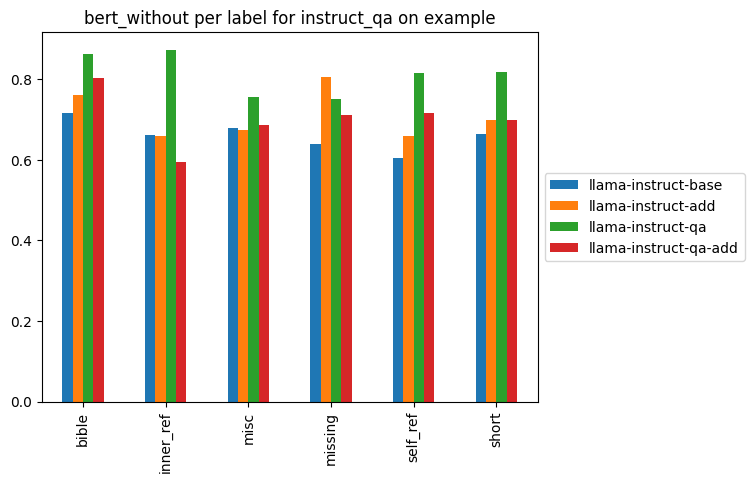

In [ ]:
plot_label_eval("bert_without", "example", "instruct_qa", ["llama-instruct-base", "llama-instruct-add", "llama-instruct-qa", "llama-instruct-qa-add"])

In [ ]:
# make a bar chart


# trying to make df to latex table...

In [ ]:
import re


class BestWorstDf():
  def __init__(self, metric, df, n=5):
    self.df = self._create_best_worst_df(df, metric, n)
    # self.df = self._escape_for_latex(self.df)

  def _combine_id_n(self, df):
    """combine id and n_footnote into one, for readability"""

    new_df = df.copy()
    new_df["id-n"] = new_df["letter_id"].astype(str) + "-" + new_df["n_footnote"].astype(str)
    new_df = new_df.drop(["letter_id", "n_footnote"], axis=1)

    # put the new column to the start
    cols = new_df.columns.tolist()
    # Move the desired column to the beginning
    cols.insert(0, cols.pop(cols.index('id-n')))
    # Reorder the DataFrame columns
    new_df = new_df[cols]
    return new_df

  def _escape_for_latex(self, df):
    new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
    new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
    return new_df

  def _create_best_worst_df(self, df, metric, n):
    best_worst_df = df.sort_values(by=metric, ascending=False)
    best_worst_df = pd.concat([best_worst_df.head(5), best_worst_df.tail(5)])

    # drop data columns that are not the metric
    drop_cols = []
    for col in best_worst_df.columns:
      if str(best_worst_df[col].dtype) == "float64" and col != metric:
        drop_cols.append(col)
    best_worst_df = best_worst_df.drop(drop_cols, axis=1)
    return best_worst_df

    return best_worst_df

  def print_latex_table(self):
    new_df = self._combine_id_n(self.df)
    new_df = self._escape_for_latex(new_df)
    # round the floats to two decimal points
    for col in new_df.columns:
      if str(new_df[col].dtype) == "float64":
        new_df[col] = new_df[col].round(2)

    # create the format:
    col_format = ""
    for col in new_df.columns:
      if str(new_df[col].dtype) == "object":
        col_format += "X"
      else:
        col_format += "c"

    table_string = (new_df.to_latex(index=False, escape=False, column_format=col_format, float_format="%.2f"))
    # add tabularx package
    table_string = table_string.replace(r"\begin{tabular}", r"\begin{tabularx}{\textwidth}")
    table_string = table_string.replace(r"\end{tabular}", r"\end{tabularx}")
    print(table_string)

def escape_latex(text):
    """Escapes special LaTeX characters in a string."""
    latex_special_chars = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(key) for key in latex_special_chars.keys()))
    return regex.sub(lambda match: latex_special_chars[match.group(0)], text)

def escape_latex_for_df(df):
    """Escapes special LaTeX characters in a dataframe."""
    for col in df.select_dtypes(include=['object']).columns:  # Apply only to string columns
        df[col] = df[col].apply(lambda x: escape_latex(str(x)) if pd.notna(x) else x)
    return df

def make_latex_table_from_df(df):
  new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
  new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
  new_df.rename(columns={"n_footnote":"n"})

    # Calculate the desired column width
  total_width = 0.95  # Adjust as needed for the desired table width relative to page width
  num_cols = len(new_df.columns)
  col_width = total_width / num_cols

  # Generate the column format string
  col_format = "llp{4cm}p{4cm}cc"

  # Convert to LaTeX with automatic text wrapping
  print(new_df.to_latex(index=False, escape=False, column_format=col_format))

  # print(new_df.to_latex(index=False, escape=False))
